<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach3/Pregunta_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales
## Tarea 3 - Redes Neuronales

### Integrantes:
* Ignacio Valenzuela Albornoz 2014073055-1
* Rodrigo González Smith 201303026-2

In [0]:
!pip install -U -q PyDrive

In [0]:
import numpy as np
import pandas as pd
import os, re, sys
import random
import math
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import LambdaCallback
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import CuDNNGRU,GRU
from keras.layers import Bidirectional
from keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.metrics import f1_score
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%matplotlib inline

##Sección 1

Utilizaremos las Redes Neuronales Recurrentes para el modelamiento de texto y lenguaje natural, en el problema particular de  procesar sentencias de texto, proporcionadas por GMB (Groningen Meaning Bank), para reconocimiento de entidades y tagger. 

Primero que todo importaremos el dataset a utilizar, el cual esta alojado en Kaggle. Posterior a su descarga, lo almacenamos en un DataFrame. Se hará el procedimiento para importar el DataSet desde Google Drive.

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile().GetList()  # Analizamos el contenido del Drive para obtener el id del archivo
for file in file_list:
  if('ner' in file['title'] ):
    print('title {}, id {}'.format(file['title'], file['id']))


title ner_dataset.csv, id 1Y6hC0qBqUBzNwN_3sJxyjqlcQjESUU5J
title ner.csv, id 1tZfMAF3cBlXXhzAb7Z9TFONLn6YBuOMn


In [0]:
download_path = os.path.expanduser('~/data') # Luego creamos un directorio local para almacenar la data
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

In [0]:
output_file = os.path.join(download_path, 'ner.csv') # Luego importamos la informacion

temp_file = drive.CreateFile({'id': '1tZfMAF3cBlXXhzAb7Z9TFONLn6YBuOMn'})
temp_file.GetContentFile(output_file)

Finalmente en el archivo output_file obtenemos el csv, el cual importamos en pandas.

In [0]:
df_ner = pd.read_csv(output_file, encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


Ahora veremos como esta compuesto el dataframe y sus atributos.

In [0]:
df_ner.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [0]:
df_ner.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

Procederemos a extraer las columnas que nos interesan para el modelo, la cuales son lemma, word, pos, tag y prev-iob. A pesar que ya tenemos el atributo word que nos indica cual es la palabra en cuestión que se analiza en esa muestra, también nos será útil el atributo lemma, ya que esta representa la palabra raíz la cual se desprenden todas sus formas flexionadas. Como varias palabras pueden venir de la misma raíz, esto para el modelo podría indicarle que estas dos palabras pueden ser distintas, siendo que representan a la misma raíz. Por esto mismo, considerar el lemma de esa palabra en vez de la flexionada ayuda a que el modelo se enfoque más en el significado de esa palabra sin temor a ambigüedades.


In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

Ahora construiremos dos estructuras, donde una almacena las palabras u oraciones y la otra almacena los tags correspondientes por cada muestra. Se comenzará creando un conjunto para cada uno ya que la idea es no tener valores repetidos.

In [0]:
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
sentence = []
labels_sentence = []
for fila in dataset.values:
  if fila[-1]=="__START1__": 
    dataX.append(np.asarray(sentence))
    dataY.append(np.asarray(labels_sentence))
    sentence= []
    labels_sentence = []
  lemmas.add(fila[0])
  labels.add(fila[3])
  sentence.append(fila[0])#add lemma
  labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[1:]) #data to  array
dataY = np.asarray(dataY[1:])

In [0]:
print(len(dataX[0]) , len(dataX[1]))
print(len(dataY[0]) , len(dataY[1]))

24 30
24 30


Con lo anterior podemos apreciar que tanto dataX y dataY poseen la misma cantidad de ejemplos, pero entre los mismos ejemplos no poseen la misma dimension, debido a que pueden haber frases mas cortas que otras. Cabe destacar, eso si, que la dimensión de los tag es la misma de las oraciones respecto al mismo índice.

Tras esto, analizaremos un poco los datos que extraímos. Primero haremos un histograma el cual compare los largos de cada oración.

In [0]:
largo = []
for element in dataX:
  largo.append(len(element))

In [0]:
print(max(largo))

81


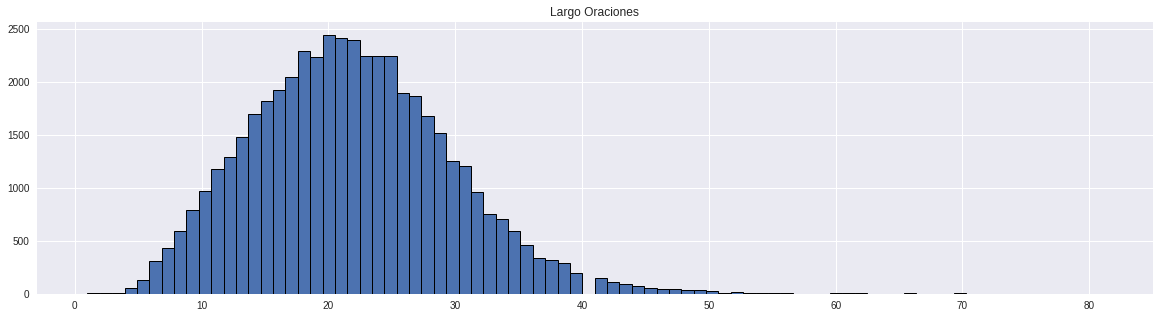

In [0]:
plt.figure(figsize=(20,5))
plt.title('Largo Oraciones')
plt.hist(largo, bins=82, alpha=1, edgecolor = 'black',  linewidth=1)
plt.grid(True)
plt.show()
plt.clf()

Aqui podemos apreciar que el histograma esta bastante centrado en oraciones de largo 20, incluso tiene aspecto de una distribución normal. Vemos también al final que es alargado, ya que el máximo es 81, lo que se podría considerar outlier, ya que esta más separado de los demás. Esto último será muy importante en la implementación del modelo.

Ahora analicemos la frecuencia de las palabras. Primero juntamos todas las palabras de las muestras en una sola lista. Luego, calculamos en otra lista la frecuencia de cada palabra por separado y luego graficamos esta aplicando el logaritmo en base 10 para comprobar si cumple con la Ley de Zipf

In [0]:
pala = []
for element in dataX:
  pala.extend(element)

In [0]:
palabras = []
for element in dataX:
  for word in element:
    if word not in palabras:
      palabras.append(word)

In [0]:
frecuencias = [0] * len(palabras)
for element in dataX:
  for word in element:
    index = palabras.index(word)
    frecuencias[index] +=1

In [0]:
frecuencias.sort(reverse=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


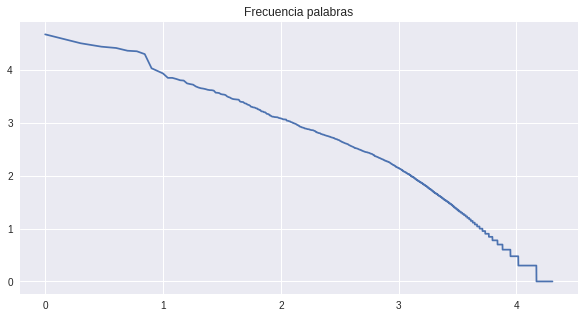

In [0]:
x = np.log10(list(range(len(frecuencias))))
plt.figure(figsize=(10,5))
plt.title('Frecuencia palabras')
plt.plot(x, np.log10(frecuencias))
plt.show()
plt.clf()

Se aprecia de forma evidente que cumple con la ley de Zipf,  la cual presenta una caída (donde la palabra siguiente sera un cierto factor de menor frecuencia que el anterior y así) y presenta el mismo patrón en la cola menor del gráfico, donde se ve como si hubieran datos discretos y se hace no continua esa función.

Antes de poder pasar estos datos a una red neuronal, debemos pre-procesar estos datos, haciendo una función que transforme los lemmas y tags a números. 

In [0]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

Luego, como vimos anteriormente, los largos de las sentencias no son las mismas para todas. Necesitamos que cada muestra (de entrada) posean la misma dimensionalidad. Para solucionar esto debemos utilizar padding, donde rellenaremos las sentencias mas cortas hasta que tenga el largo de la sentencia de largo más alto, donde en celdas anteriores descubrimos que era de 81. Esto igualmente para los tags.

Respecto a usar pre o post padding puede tener dos enfoques, uno respecto a la importancia en el dataset y el otro de forma computacional. Principalemente usar pre o post padding va a depender de qué tan importante es el pasado o el futuro para poder categorizar los lemmas en cada sentencia. Por la parte computacional, se podría dar preferencia al pre padding debido al back propagation, ya que empezando con valores 0 puede evitar la explosión del gradiente, haciendo el entrenamiento de los pesos compartidos de forma menos brusca, sobre todo cuando se aplican sentencias muy cortas.
Por esto se decidió utilizar pre padding para equiparar las dimensiones de todas las sentencias, además que así mientras mas avance el input en la red recurrente, obtendremos outputs finales con información útil y no con muchos 0, sobre todo considerando que la mayoría de sentencias (por el histograma anterior) se concentra en largo 20, cuando la dimensionalidad total es de 81, por lo tanto habría muchas iteraciones (que contienen valor 0) después del último lemma, lo que afectaría en como se entrena posteriormente.

In [0]:
lemma2idx["ENDLEM"] = 0
lab2idx["ENDTAG"] = 0
X = sequence.pad_sequences(dataX,maxlen=81,padding='pre',value=lemma2idx["ENDLEM"]) 
y = sequence.pad_sequences(dataY,maxlen=81,padding='pre',value=lab2idx["ENDTAG"])

Debido a que esta codificado en números enteros, debemos pasarlo a one hot vectors, definiendo bien el rango de valores para todas las sentencias.

In [0]:
Y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=22)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33656, 81) (14425, 81) (33656, 81, 17) (14425, 81, 17)


Se puede apreciar los shapes de cada conjunto, donde tenemos el x que posee las muestras y el largo de ellas (81 debido al máximo largo que pueden tener) y por parte del conjunto de validación tenemos una dimensión extra que representa la cantidad de tags disponibles.

Ahora se procederá a crear el modelo, el cual consiste en una red neuronal recurrente con compuertas LSTM para que esta red pueda aprendar a taggear las entidades en el texto. Se define un vector de embedding de 32 para comenzar, el cual nos ayudará a mapear los valores discretos de la entrada a unos pertenecientes ${\rm I\!R}^{32}$ específicamente en este caso. Luego se agrega la capa LSTM con 100 unidades y finalmente la capa densa que obtendrá los outputs.

In [0]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647776    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 17)            1717      
Total params: 702,693
Trainable params: 702,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 69s 2ms/step - loss: 0.5039 - val_loss: 0.2109
Epoch 2/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.1539 - val_loss: 0.1004
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.0781 - val_loss: 0.0646


Vemos que los datos al pasar a la red, cambian a una dimensionalidad mayor que es 32. Claramente, debido a los tags que puede representar, estos deben salir con una dimensionalidad de 17 indicando el tag correspondiente. 

In [0]:
aux_y_test = np.ndarray.flatten(np.argmax(y_test, axis=2))
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
y_nozero = np.where(aux_y_test != 0)
print("F1 score on test: ", f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted'))

F1 score on test:  0.9410811488007655


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Ahora, sabiendo que el vector de embedding transforma nuestra entrada a más dimensiones, es interesante investigar como afecta la dimensionalidad de la entrada en el proceso y también en el accuracy obtenido. La idea es ocupar dos valores equidistantes del ya utilizado anteriormente, uno de menor dimensión y otro de mayor, 16 y 48 respectivamente. Dentro de un for se realizaran los modelos y se imprimirá los resultados.

In [0]:
for embedding_vector in [16, 48]:
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
  model.add(LSTM(units=100,return_sequences=True))
  model.add(Dense(n_labels, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
  y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
  print("F1 score on test with embedding dimension = " + str(embedding_vector)+ ":", f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323888    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 17)            1717      
Total params: 372,405
Trainable params: 372,405
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.5297 - val_loss: 0.2343
Epoch 2/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1946 - val_loss: 0.1425
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1129 - val_loss: 0.0938


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score on test with embedding dimension = 16: 0.8875135971130335
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 48)            971664    
_________________________________________________________________
lstm_3 (LSTM)                (None, 81, 100)           59600     
_________________________________________________________________
dense_3 (Dense)              (None, 81, 17)            1717      
Total params: 1,032,981
Trainable params: 1,032,981
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 68s 2ms/step - loss: 0.4622 - val_loss: 0.1946
Epoch 2/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.1333 - val_loss: 0.0927
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step -

Vemos una clara superioridad del embedding de 48 respecto al de 16, por lo que podríamos intuir que aumentando la dimensión del embedding la red debiese mejorar su accuracy al predecir los tags de las entidades. Esto puede deberse a que si se va aumentando aún más la dimensionalidad del conjunto de datos, para el modelo es mucho más fácil identificar y separar por clases la información.

Otro método que podría mejorar el desempeño es el uso de reguladores. Dropout es uno de los que, en tareas anteriores, dió buenos resultados en ciertos modelos. La idea ahora es aplicarlo posterior a la unidad LSTM. La idea de aplicar el dropout es que pueda hacer un mejor entrenamiento de los pesos compartidos, aunque también podría ser que este mismo Dropout pueda afectar a la forget gate, lo que podría afectar en la memoria de la unidad durante el entrenamiento.

In [43]:
modelD = Sequential()
modelD.add(Embedding(input_dim=n_lemmas, output_dim=32, input_length=81))
modelD.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
modelD.add(Dropout(0.2))
modelD.add(Dense(n_labels, activation='softmax'))
modelD.compile(loss='categorical_crossentropy', optimizer='adam')
modelD.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 68s 2ms/step - loss: 0.4921 - val_loss: 0.2152
Epoch 2/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.1605 - val_loss: 0.1067
Epoch 3/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.0861 - val_loss: 0.0681


In [44]:
y_pred = np.ndarray.flatten(np.argmax(modelD.predict(X_test, verbose=0), axis = 2))
print("F1 score on test: ", f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted'))

F1 score on test:  0.9312365631078734


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Podemos ver que el desempeño aplicando Dropout sigue siendo bueno, aunque no supera el obtenido con el embedding 32 sin el Dropout. Debido a las razones explicadas anteriormente, puede haber cierta memoria que pierde el modelo, lo que en ciertos casos tiende a tener ciertas predicciones erróneas, aunque tampoco es para concluir que la aplicación de Dropout no es efectiva o empeora demasiado el desempeño.

Hasta ahora, solo se ha implementado el modelo viendo las dependencias anteriores en cada sentencia, pero sería importante tener cierta visión del "futuro" considerando las palabras que vienen después de otra, por lo que una implementación bidireccional es la opción. Esto nos permite ver las dependencias en ambos sentidos y, analizando los valores de los tags, puede tener una repercusión bastante alta en el desempeño. Respecto al tipo de merge que se puede usar, se comprobarán los cuatro para ver cual obtiene un mejor desempeño.

In [64]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
concat = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 81, 32)            647776    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_14 (Dense)             (None, 81, 17)            3417      
Total params: 757,593
Trainable params: 757,593
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/8
33656/33656 [==============================] - 131s 4ms/step - loss: 0.3854 - val_loss: 0.1874
Epoch 2/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.1326 - val_loss: 0.0984
Epoch 3/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.0769 - val_loss: 0.0647
Epoch 4/8
33656/33656 [============

In [66]:
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
concat_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [67]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
suma = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
sum_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 81, 32)            647776    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 81, 100)           106400    
_________________________________________________________________
dense_15 (Dense)             (None, 81, 17)            1717      
Total params: 755,893
Trainable params: 755,893
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/8
33656/33656 [==============================] - 131s 4ms/step - loss: 0.3688 - val_loss: 0.1900
Epoch 2/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.1396 - val_loss: 0.1002
Epoch 3/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.0746 - val_loss: 0.0611
Epoch 4/8
33656/33656 [============

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [68]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='mul'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
mul = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
mul_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 81, 32)            647776    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 81, 100)           106400    
_________________________________________________________________
dense_16 (Dense)             (None, 81, 17)            1717      
Total params: 755,893
Trainable params: 755,893
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/8
33656/33656 [==============================] - 132s 4ms/step - loss: 0.5512 - val_loss: 0.1956
Epoch 2/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.1340 - val_loss: 0.0953
Epoch 3/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.0746 - val_loss: 0.0658
Epoch 4/8
33656/33656 [============

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [69]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='ave'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
ave = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
ave_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 81, 32)            647776    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 81, 100)           106400    
_________________________________________________________________
dense_17 (Dense)             (None, 81, 17)            1717      
Total params: 755,893
Trainable params: 755,893
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/8
33656/33656 [==============================] - 132s 4ms/step - loss: 0.4322 - val_loss: 0.2033
Epoch 2/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.1675 - val_loss: 0.1244
Epoch 3/8
33656/33656 [==============================] - 126s 4ms/step - loss: 0.1027 - val_loss: 0.0875
Epoch 4/8
33656/33656 [============

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


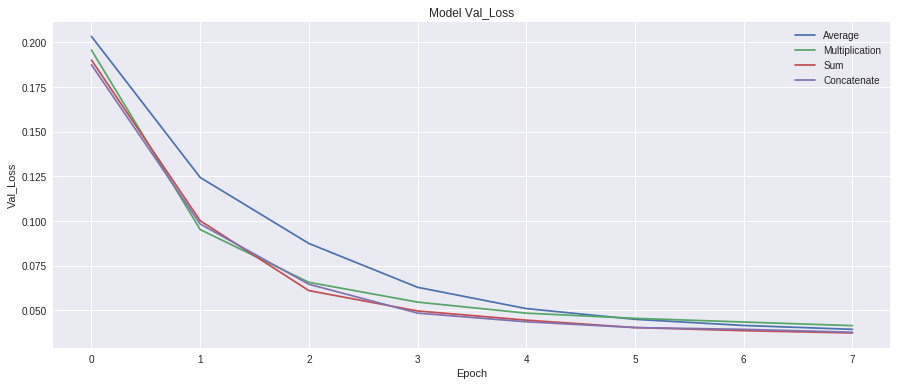

In [70]:
plt.figure(figsize=(15,6))
plt.plot(ave.history['val_loss'])
plt.plot(mul.history['val_loss'])
plt.plot(suma.history['val_loss'])
plt.plot(concat.history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Val_Loss')
plt.legend(['Average', 'Multiplication', 'Sum', 'Concatenate'], loc='upper right')
plt.show()

A pesar de que convergen a valores muy cercanos, se ve que el que posee mejor desempeño es el Sum, teniendo al average casi como el peor, comienza con error alto pero al converger mejora sus valores, siendo el de multiplicación el que posee problemas.

Debido a la gran cantidad de sentencias que poseen ceros (como se vio en el histograma, la sentencia de largo 81, que es el máximo, tiene una gran diferencia con el largo de las demás, por lo que la mayoría de las sentencias poseen muchos 0 por el padding) sería útil ocupar una capa de masking el cual nos ayude a esconder esta "ausencia" de información para las dimensiones mas grandes. Para eso, antes de ingresar los datos a la unidad LSTM se realiza el mask_zero=True. Para comprobar como se va entrenando la red, se realizará una cantidad mayor de epochs para poder apreciar mejor su comportamiento en una gráfica.

In [61]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81, mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
mask = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
mask_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 81, 32)            647776    
_________________________________________________________________
lstm_13 (LSTM)               (None, 81, 100)           53200     
_________________________________________________________________
dense_13 (Dense)             (None, 81, 17)            1717      
Total params: 702,693
Trainable params: 702,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/15
33656/33656 [==============================] - 92s 3ms/step - loss: 0.8436 - val_loss: 0.4316
Epoch 2/15
33656/33656 [==============================] - 87s 3ms/step - loss: 0.3757 - val_loss: 0.3411
Epoch 3/15
33656/33656 [==============================] - 88s 3ms/step - loss: 0.2944 - val_loss: 0.2584
Epoch 4/15
33656/33656 [===========

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


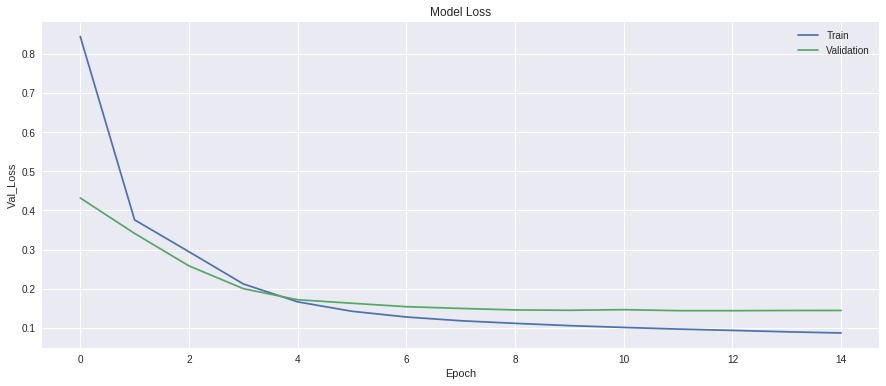

In [63]:
plt.figure(figsize=(15,6))
plt.plot(mask.history['loss'])
plt.plot(mask.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Val_Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [65]:
print(mask_score)

0.9671433262047205


Primero que todo vemos que los tiempos de entrenamiento se han reducido comparado a los modelos anteriores, donde podemos ver que por cada epoch se demora entre 120 a 130 [sg], mientras que con el masking se demora entre 87 a 92 [sg], lo que es casi medio minuto menos. Esto se debe principalmente a la misma máscara, la cual no considera estos valores de 0 presentes.

Respecto a la curva de entrenamiento vemos que comienza con un error más alto que los otros modelos, pero mientras se aumenta los epoch logra llegar a valores parecidos. Por lo tanto podemos decir que aplicando masking la convergencia es mas lenta además que se acerca a un valor mayor que los otros modelos anteriores.

Aun así donde destaca es en su score, el cual es el modelo que mejor ha obtenido resultados con un 0.96. Por lo tanto vemos que la ampliación de las sentencias con padding influye de gran manera al desempeño de la red.

Tras todo el análisis anterior, la idea ahora es intentar tomar las variaciones que lograron un mejor desempeño y ver si en conjunto pueden potenciar aún más el aprendizaje de la red. Luego de esto, se tomará el mismo modelo y se le cambiara el gate por GRU. Con esto tendremos 2 modelos, los cuales probaremos su desempeño y veremos si logramos aumentar más el score.

Por lo anterior, sabemos que se obtuvieron buenos desempeños aplicando masking a las sentencias, ocupando un embedding con dimensión alta, modelo bidireccional con un merge_mode = sum y aumentando a 120 las unidades en la capas, sea LSTM o GRU.

In [71]:
embedding_vector = 48
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81, mask_zero=True))
layer_lstm = LSTM(units=120,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
best = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
best_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 81, 48)            971664    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 81, 120)           162240    
_________________________________________________________________
dense_18 (Dense)             (None, 81, 17)            2057      
Total params: 1,135,961
Trainable params: 1,135,961
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/10
33656/33656 [==============================] - 175s 5ms/step - loss: 0.6876 - val_loss: 0.3505
Epoch 2/10
33656/33656 [==============================] - 168s 5ms/step - loss: 0.2496 - val_loss: 0.1939
Epoch 3/10
33656/33656 [==============================] - 167s 5ms/step - loss: 0.1570 - val_loss: 0.1550
Epoch 4/10
33656/33656 [====

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [72]:
## GRU
embedding_vector = 48
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81, mask_zero=True))
layer_gru = GRU(units=120,return_sequences=True)
model.add(Bidirectional(layer_gru, merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
gru = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis = 2))
gru_score = f1_score(aux_y_test[y_nozero], y_pred[y_nozero], average='weighted')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 81, 48)            971664    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 81, 120)           121680    
_________________________________________________________________
dense_19 (Dense)             (None, 81, 17)            2057      
Total params: 1,095,401
Trainable params: 1,095,401
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/10
33656/33656 [==============================] - 140s 4ms/step - loss: 0.6255 - val_loss: 0.2712
Epoch 2/10
33656/33656 [==============================] - 133s 4ms/step - loss: 0.1952 - val_loss: 0.1611
Epoch 3/10
33656/33656 [==============================] - 133s 4ms/step - loss: 0.1296 - val_loss: 0.1383
Epoch 4/10
33656/33656 [====

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [73]:
print("LSTM = " , best_score)
print("GRU = ", gru_score)

LSTM =  0.9708988975846343
GRU =  0.9721138650862691


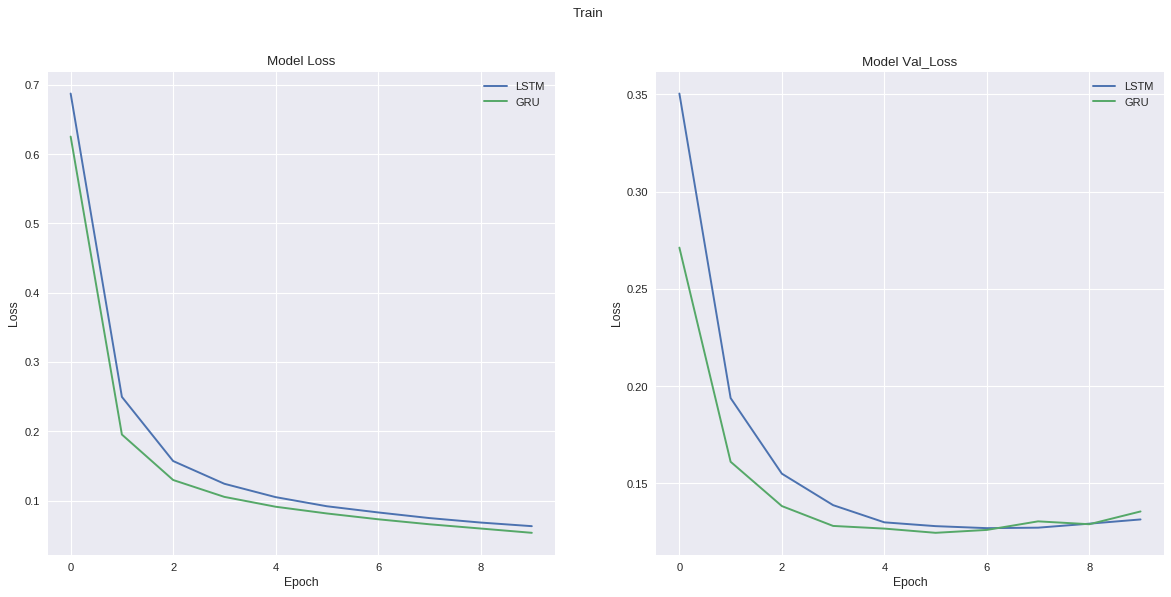

In [74]:
plt.figure(figsize=(18, 8), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("Train")
plt.plot(best.history['loss'])
plt.plot(gru.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['LSTM', 'GRU'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(best.history['val_loss'])
plt.plot(gru.history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['LSTM','GRU'], loc='upper right')
plt.grid(True)
plt.show()

Podemos apreciar que en ambos modelos logramos mejorar el desempeño ahora hasta un 0.97, siendo GRU el que obtiene un mejor desempeño con 0.972. Además vemos en el gráfico que la función de loss en ambos conjuntos están disminuyendo casi a la par, por lo que no hay presencia de overfitting. En general, son muy buenos resultados, por lo que se mantendrá el modelo GRU como el mejor.

l

In [75]:
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

NameError: ignored

## Sección 2

Ahora nos enfocaremos en otra aplicación, la cual es el autocompletado, función muy usada hoy en día la cual, tras una cierta cadena de palabras, se intenta predecir la palabra que viene después. Esta aplicación ha sido muy utilizada en teclados de celulares, por ejemplo. 

Debido que ahora, tras una gran cantidad de sentencias (que arman la frase previa) se intenta predecir una palabra, pasamos de un esquema *manytomany* a uno *manytoone*. El problema surge que con esta gran cantidad de palabras que hay en el dataset, habrán muchas posibilidades de combinación para sugerir cual será la siguiente palabra, lo que no sería muy práctico para el problema. Lo que se hará es tomar estas palabras y analizarlas por carácteres en vez del conjunto de ellas, ya que sabemos que, por lo menos en el alfabeto inglés, posee una cantidad de 27, lo que es una cantidad aceptable. 

En esta ocasión debemos tratar de nuevo los datos del dataset, aunque en esta ocasión trabajaremos con la columna word en vez de lemma. Esto es debido a que ahora, como queremos predecir la palabra siguiente, no nos sirve tener el lemma de este (o el significado raíz) ya que no estaría considerando un elemento básico como la semántica de las frases produciendo frases sin sentido.  Luego de eso se hace la ya conocida transformación de carácter a números.

In [95]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 242693


In [0]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
lemma2idx["ENDLEM"] = 0
lab2idx["ENDTAG"] = 0
X = sequence.pad_sequences(dataX,maxlen=41,padding='pre',value=lemma2idx["ENDLEM"]) 
Y = np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])

Luego de hacer la transformación a números, se hace el padding correspondiente a los datos de entrada y se pasa a one hot vector los tags. Se procede a crear un modelo y entrenarlo aunque con esta vez con GRU (en estricto rigor CuDNNGRU, una librería de CUDA que acelera el proceso de GRU).

In [0]:
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Luego, se implementarán dos funciones las cuales se encargaran de predecir la siguiente palabra de forma consecutiva por cada epoch, para así ver el desempeño de la red mientras se entrena. 

In [0]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]

def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [105]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
newmodel = model.fit(X, Y,batch_size=256,epochs=25, callbacks=[print_callback])

Epoch 1/25
242693/242693 [==============================] - 46s 188us/step - loss: 1.6658 - acc: 0.5111

----- Generating text after Epoch: 0
----- Generating with seed: "d in earlier fighting . a turkish army s"
d in earlier fighting . a turkish army said from from meg tiandy suspectide ef upfition by a supplier the two vone lugan 's unitre palist nuts of with the cante the usian reluca of agtace . but e poreneswan to united engoping says mres hwreakh of at chowh authorities to folemence . decondury vithous kr. concrives friday changed world farle 1ug to the thrie of fron the government . ani monto . a compunuster prime mikidation invasting ngaEpoch 2/25
242693/242693 [==============================] - 46s 189us/step - loss: 1.5082 - acc: 0.5543

----- Generating text after Epoch: 1
----- Generating with seed: " tv channel al-jazeera broadcast a video"
 tv channel al-jazeera broadcast a video targ government davis say he dispopecle for strukgori trankiller violence hod authorities in 

In [106]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is the movests . the gonss of the devoly will bowhs . no accides to dearing not say a nuclears conside , says has relayists and north of chiscomms leganies . a north of counted obemict , wes in golnan jauch beta bombarad probe . he say for from legons of decrines cive of cherress of burner unst of the geppanes and other of the ground 5 % . north . rescues includ islami . troigs to horeing prosecomnan